In [1]:
import os
import librosa
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Bidirectional, LSTM ,Flatten ,Reshape

In [2]:
SR=22050
N_MFCC=40
N_MELS=128
DURATION=3
SAMPLES_PER_TRACK=SR*DURATION
CLASSES=['AssaultRifle','MachineGun','Noise']

In [3]:
def extract_features(file_path):
    y,sr=librosa.load(file_path,sr=SR,duration=DURATION)
    if len(y)<SAMPLES_PER_TRACK:
        y=np.pad(y,(0,SAMPLES_PER_TRACK-len(y)))
    else:
        y=y[:SAMPLES_PER_TRACK]
    mfcc=librosa.feature.mfcc(y=y,sr=sr,n_mfcc=N_MFCC)
    mfcc=librosa.util.fix_length(mfcc,size=174,axis=1)
    mfcc=mfcc[...,np.newaxis]
    mel_spec=librosa.feature.melspectrogram(y=y,sr=sr)
    mel_spec=librosa.power_to_db(mel_spec,ref=np.max)
    # plt.figure(figsize=(10,6))
    # librosa.display.specshow(mel_spec,sr=SR,x_axis='time',y_axis='mel')
    # plt.colorbar(format='%+2.0f dB')
    # plt.title('Mel-Spectogram')
    # plt.tight_layout()
    # plt.show()
    mel_spec=librosa.util.fix_length(mel_spec,size=174,axis=1)
    mel_spec=mel_spec[...,np.newaxis]
    return mfcc,mel_spec

In [4]:
def load_dataset(dataset_path):
    x_mfcc,x_melspec,y=[],[],[]
    for i,class_name in enumerate(CLASSES):
        class_dir=os.path.join(dataset_path,class_name)
        for file_name in os.listdir(class_dir):
            if file_name.endswith(".wav"):
                file_path=os.path.join(class_dir,file_name)
                mfcc,mel_spec=extract_features(file_path)
                x_mfcc.append(mfcc)
                x_melspec.append(mel_spec)
                y.append(i)
    x_mfcc=np.array(x_mfcc)
    x_melspec=np.array(x_melspec)
    y=to_categorical(y,num_classes=len(CLASSES))
    return x_mfcc,x_melspec,y


In [5]:
X_mfcc,X_melspec,y=load_dataset('3s_dataset')

In [6]:
X_melspec.shape

(789, 128, 174, 1)

In [7]:
X_mfcc.shape

(789, 40, 174, 1)

In [8]:
X_mfcc_trainval, X_mfcc_test, X_melspec_trainval, X_melspec_test, y_trainval, y_test = train_test_split(
    X_mfcc, X_melspec, y, test_size=0.3, random_state=2
)

# Then, split the training+validation set into training and validation sets
X_mfcc_train, X_mfcc_val, X_melspec_train, X_melspec_val, y_train, y_val = train_test_split(
    X_mfcc_trainval, X_melspec_trainval, y_trainval, test_size=0.2, random_state=2
)

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, Dense, Input, Reshape, Bidirectional, LSTM, Layer
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1]),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(shape=(input_shape[-1],),
                                 initializer='zeros',
                                 trainable=True)
        self.u = self.add_weight(shape=(input_shape[-1], 1),
                                 initializer='glorot_uniform',
                                 trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, inputs, **kwargs):
        # v: (batch_size, sequence_length, hidden_dim)
        v = K.tanh(K.dot(inputs, self.W) + self.b)
        
        # vu: (batch_size, sequence_length, 1) -> alignment scores
        vu = K.dot(v, self.u)
        
        # Apply softmax to compute attention weights
        attention_weights = K.softmax(vu, axis=1)
        
        # Compute context vector as a weighted sum of inputs
        # weighted_sum: (batch_size, hidden_dim)
        weighted_sum = K.sum(inputs * attention_weights, axis=1)
        return weighted_sum

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]


# Function to create the model with BiLSTM and attention
def create_model(input_shape_mfcc, input_shape_melspec, num_classes=3):
    input_mfcc = Input(shape=input_shape_mfcc, name='mfcc_input')
    x_mfcc = Conv2D(16, kernel_size=(3, 3), activation='relu')(input_mfcc)
    x_mfcc = MaxPooling2D(pool_size=(2, 2))(x_mfcc)
    x_mfcc = Dropout(0.3)(x_mfcc)

    x_mfcc = Conv2D(32, kernel_size=(3, 3), activation='relu')(x_mfcc)
    x_mfcc = MaxPooling2D(pool_size=(2, 2))(x_mfcc)
    x_mfcc = Dropout(0.3)(x_mfcc)

    x_mfcc = Conv2D(64, kernel_size=(3, 3), activation='relu')(x_mfcc)
    x_mfcc = MaxPooling2D(pool_size=(1, 2))(x_mfcc)
    x_mfcc = Dropout(0.3)(x_mfcc)

    x_mfcc = Conv2D(128, kernel_size=(3, 3), activation='relu')(x_mfcc)
    x_mfcc = MaxPooling2D(pool_size=(2, 2))(x_mfcc)
    x_mfcc = Dropout(0.3)(x_mfcc)

    x_mfcc = Reshape((-1, x_mfcc.shape[-1]))(x_mfcc)

    input_melspec = Input(shape=input_shape_melspec, name='melspec_input')
    x_melspec = Conv2D(16, kernel_size=(3, 3), activation='relu')(input_melspec)
    x_melspec = MaxPooling2D(pool_size=(2, 2))(x_melspec)
    x_melspec = Dropout(0.3)(x_melspec)

    x_melspec = Conv2D(32, kernel_size=(3, 3), activation='relu')(x_melspec)
    x_melspec = MaxPooling2D(pool_size=(2, 2))(x_melspec)
    x_melspec = Dropout(0.3)(x_melspec)

    x_melspec = Conv2D(64, kernel_size=(3, 3), activation='relu')(x_melspec)
    x_melspec = MaxPooling2D(pool_size=(2, 2))(x_melspec)
    x_melspec = Dropout(0.3)(x_melspec)

    x_melspec = Conv2D(128, kernel_size=(3, 3), activation='relu')(x_melspec)
    x_melspec = MaxPooling2D(pool_size=(2, 2))(x_melspec)
    x_melspec = Dropout(0.3)(x_melspec)

    x_melspec = Reshape((-1, x_melspec.shape[-1]))(x_melspec)

    # Ensure both sequences are of the same length for concatenation
    if x_mfcc.shape[1] != x_melspec.shape[1]:
        min_length = min(x_mfcc.shape[1], x_melspec.shape[1])
        x_mfcc = x_mfcc[:, :min_length, :]
        x_melspec = x_melspec[:, :min_length, :]

    concatenated = tf.keras.layers.concatenate([x_mfcc, x_melspec])

    # BiLSTM with attention
    x = Bidirectional(LSTM(128, return_sequences=True))(concatenated)
    x = Attention()(x)

    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=[input_mfcc, input_melspec], outputs=output)
    return model


In [10]:
#import tensorflow as tf
#from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,GlobalAveragePooling2D,Dense,Input,GlobalAveragePooling1D
#from tensorflow.keras.models import Model
#def create_model(input_shape_mfcc,input_shape_melspec,num_classes=3):
#    input_mfcc=Input(shape=input_shape_mfcc,name='mfcc_input')
#    x_mfcc=Conv2D(16,kernel_size=(3,3),activation='relu')(input_mfcc)
#    x_mfcc=MaxPooling2D(pool_size=(2,2))(x_mfcc)
#    x_mfcc=Dropout(0.3)(x_mfcc)
#
#    x_mfcc=Conv2D(32,kernel_size=(3,3),activation='relu')(x_mfcc)
#    x_mfcc=MaxPooling2D(pool_size=(2,2))(x_mfcc)
#    x_mfcc=Dropout(0.3)(x_mfcc)
#
#    x_mfcc=Conv2D(64,kernel_size=(3,3),activation='relu')(x_mfcc)
#    x_mfcc=MaxPooling2D(pool_size=(1,2))(x_mfcc)
#    x_mfcc=Dropout(0.3)(x_mfcc)
#    
#    x_mfcc=Conv2D(128,kernel_size=(3,3),activation='relu')(x_mfcc)
#    x_mfcc=MaxPooling2D(pool_size=(2,2))(x_mfcc)
#    x_mfcc=Dropout(0.3)(x_mfcc)
#    
#    #x_mfcc=GlobalAveragePooling2D()(x_mfcc)
#    #x_mfcc = Flatten()(x_mfcc)
#    #x_mfcc = Reshape((x_mfcc.shape[1] * x_mfcc.shape[2], 128))(x_mfcc)
#    x_mfcc = Reshape((-1, x_mfcc.shape[-1]))(x_mfcc)
#
#    input_melspec=Input(shape=input_shape_melspec,name='melspec_input')
#    x_melspec=Conv2D(16,kernel_size=(3,3),activation='relu')(input_melspec)
#    x_melspec=MaxPooling2D(pool_size=(2,2))(x_melspec)
#    x_melspec=Dropout(0.3)(x_melspec)
#
#    x_melspec=Conv2D(32,kernel_size=(3,3),activation='relu')(x_melspec)
#    x_melspec=MaxPooling2D(pool_size=(2,2))(x_melspec)
#    x_melspec=Dropout(0.3)(x_melspec)
#
#    x_melspec=Conv2D(64,kernel_size=(3,3),activation='relu')(x_melspec)
#    x_melspec=MaxPooling2D(pool_size=(2,2))(x_melspec)
#    x_melspec=Dropout(0.3)(x_melspec)
#
#    x_melspec=Conv2D(128,kernel_size=(3,3),activation='relu')(x_melspec)
#    x_melspec=MaxPooling2D(pool_size=(2,2))(x_melspec)
#    x_melspec=Dropout(0.3)(x_melspec)
#
#    #x_melspec = GlobalAveragePooling2D()(x_melspec)
#    #x_melspec =  Flatten()(x_melspec)
#    #x_melspec = Reshape((x_melspec.shape[1] * x_melspec.shape[2], 40))(x_melspec)
#    x_melspec = Reshape((-1, x_melspec.shape[-1]))(x_melspec)
#
#    # Ensure both sequences are of the same length for concatenation
#    if x_mfcc.shape[1] != x_melspec.shape[1]:
#        min_length = min(x_mfcc.shape[1], x_melspec.shape[1])
#        x_mfcc = x_mfcc[:, :min_length, :]
#        x_melspec = x_melspec[:, :min_length, :]
#        
#    concatenated=tf.keras.layers.concatenate([x_mfcc,x_melspec])
#
#    x=Bidirectional(LSTM(128, return_sequences=False))(concatenated)
#    #x = GlobalAveragePooling1D()(x)
#    x=Dense(64,activation='relu')(x)
#    x=Dropout(0.3)(x)
#    output=Dense(num_classes,activation='softmax')(x)
#
#    model=Model(inputs=[input_mfcc,input_melspec],outputs=output)
#    return model

In [11]:
input_shape_mfcc=(40,174,1)
input_shape_melspec=(128,174,1)
model=create_model(input_shape_mfcc,input_shape_melspec,num_classes=3)


In [12]:
from tensorflow.keras.metrics import AUC
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy','Precision',AUC(),'Recall'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ mfcc_input          │ (None, 40, 174,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ melspec_input       │ (None, 128, 174,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 38, 172,   │        160 │ mfcc_input[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 126, 172,  │        160 │ melspec_input[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 19, 86,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 63, 86,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 19, 86,    │          0 │ max_pooling2d[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 63, 86,    │          0 │ max_pooling2d_4[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 17, 84,    │      4,640 │ dropout[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 61, 84,    │      4,640 │ dropout_4[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 8, 42, 32) │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 30, 42,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 8, 42, 32) │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 30, 42,    │          0 │ max_pooling2d_5[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 6, 40, 64) │     18,496 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 28, 40,    │     18,496 │ dropout_5[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 6, 20, 64) │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 671,235 (2.56 MB)

 Trainable params: 671,235 (2.56 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
X_mfcc_test.shape

(237, 40, 174, 1)

In [14]:
#checkpoint=tf.keras.callbacks.ModelCheckpoint('best_model.keras',monitor='val_accuracy',save_best_only=True,mode='max')
#stoppoint=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3,restore_best_weights=True,mode=max)
#history=model.fit([X_mfcc_train,X_melspec_train],y_train,validation_data=([X_mfcc_val,X_melspec_val],y_val),epochs=40,batch_size=32,callbacks=[checkpoint])
## if stoppoint.stopped_epoch > 0:
##     print(f"Training stopped at epoch {stoppoint.stopped_epoch + 1}")
## else:
##     print("Training did not stop early.")
##model.load_weights('best_model.keras')
#results=model.evaluate([X_mfcc_test,X_melspec_test],y_test)
#test_loss,test_accuracy=results[0],results[1]
#print(f'Test Accuracy:{test_accuracy*100:.2f}%')
#print(f'Test Loss:{test_loss*100:.2f}%')

Epoch 1/80


c:\Users\abhin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['mfcc_input', 'melspec_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 321ms/step - Precision: 0.3273 - Recall: 0.1067 - accuracy: 0.3763 - auc: 0.5421 - loss: 1.1222 - val_Precision: 0.6269 - val_Recall: 0.3784 - val_accuracy: 0.5766 - val_auc: 0.7886 - val_loss: 0.8513
Epoch 2/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 220ms/step - Precision: 0.5825 - Recall: 0.3509 - accuracy: 0.5342 - auc: 0.7458 - loss: 0.9034 - val_Precision: 0.6515 - val_Recall: 0.3874 - val_accuracy: 0.6216 - val_auc: 0.8012 - val_loss: 0.8124
Epoch 3/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - Precision: 0.6467 - Recall: 0.4661 - accuracy: 0.6430 - auc: 0.8344 - loss: 0.7373 - val_Precision: 0.5657 - val_Recall: 0.5045 - val_accuracy: 0.5495 - val_auc: 0.7787 - val_loss: 0.8998
Epoch 4/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step - Precision: 0.6904 - Recall: 0.6337 - accuracy: 0.6799 - auc: 0.8599 - loss: 0.6734 - val_Precision: 0.7925 - val_Recall: 0.7568 - val_accuracy: 0.7748 - val_auc: 0.9164 - val_loss: 0.5865
Epoch 5/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 1

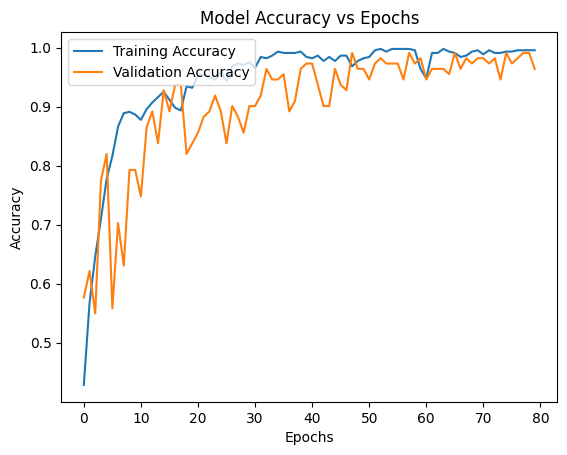

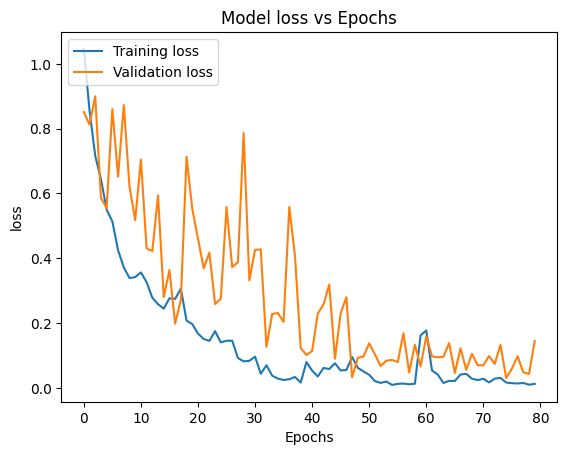

In [15]:
#import matplotlib.pyplot as plt

checkpoint=tf.keras.callbacks.ModelCheckpoint('best_model.keras',monitor='val_accuracy',save_best_only=True,mode='max')
losscheck=tf.keras.callbacks.ModelCheckpoint('best_model.keras',monitor='val_loss',save_best_only=True,mode='min')
# Assuming `model` is your compiled model and you have train and validation data
history = model.fit([X_mfcc_train, X_melspec_train], y_train, 
                    validation_data=([X_mfcc_val, X_melspec_val], y_val),
                    epochs=80,  # Number of epochs you want to train
                    batch_size=32,callbacks=[checkpoint,losscheck])


results=model.evaluate([X_mfcc_test,X_melspec_test],y_test)
test_loss,test_accuracy=results[0],results[1]
print(f'Test Accuracy:{test_accuracy*100:.2f}%')
print(f'Test Loss:{test_loss*100:.2f}%')


#Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

# Adding labels and title
plt.title('Model Accuracy vs Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='upper left')

epochs = len(history.history['accuracy'])
plt.xticks(np.arange(0, epochs+1, 10))  # Scale of 10 on x-axis


# Display the plot
plt.show()



plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')

# Adding labels and title
plt.title('Model loss vs Epochs')
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.legend(loc='upper left')

epochs = len(history.history['loss'])
plt.xticks(np.arange(0, epochs+1, 10))  # Scale of 10 on x-axis


# Display the plot
plt.show()





In [16]:
results

[0.1844123750925064,
 0.9367088675498962,
 0.9367088675498962,
 0.9938712120056152,
 0.9367088675498962]